In [92]:
# imports

import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import requests
import zipfile
from pathlib import Path

import random
from PIL import Image


import numpy as np

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from timeit import default_timer as timer
import splitfolders

# Import tqdm for progress bar
from tqdm.auto import tqdm
from torchinfo import summary


from helper_functions import accuracy_fn
from helper_functions import plot_loss_curves
from going_modular.going_modular import data_setup, engine
from going_modular.going_modular.utils import save_model
from going_modular.going_modular.predictions import pred_and_plot_image
import seaborn as sns

# Check version
print(torch.__version__)
print(torchvision.__version__)

1.13.1
0.14.1


In [ ]:
# splitfolders.ratio('CASIA_DATA_SET', output="CASIA_DATA_SET_SPLITED", seed=1337, ratio=(0.8, 0.2))

In [2]:
# Setup path to a data forlder

image_path = Path("CASIA_DATA_SET_SPLITED")

In [3]:
# Walk throguh the dataset 

def walk_throguh_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [4]:
walk_throguh_dir(image_path)

There are 3 directories and 1 images in 'CASIA_DATA_SET_SPLITED'
There are 0 directories and 1 images in 'CASIA_DATA_SET_SPLITED\.ipynb_checkpoints'
There are 2 directories and 0 images in 'CASIA_DATA_SET_SPLITED\test'
There are 0 directories and 4000 images in 'CASIA_DATA_SET_SPLITED\test\without_mask'
There are 0 directories and 4000 images in 'CASIA_DATA_SET_SPLITED\test\with_mask'
There are 2 directories and 0 images in 'CASIA_DATA_SET_SPLITED\train'
There are 0 directories and 16000 images in 'CASIA_DATA_SET_SPLITED\train\without_mask'
There are 0 directories and 16000 images in 'CASIA_DATA_SET_SPLITED\train\with_mask'


In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('CASIA_DATA_SET_SPLITED/train'),
 WindowsPath('CASIA_DATA_SET_SPLITED/test'))

In [1]:
# img = mpimg.imread('CASIA_DATA_SET_SPLITED/train/with_mask/1(10).jpg')
# imgplot = plt.imshow(img)
# plt.show()

In [6]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create our pretrained weights

In [7]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [8]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, 
                                                                               batch_size=32) 

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x180d83d1c40>,
 ['with_mask', 'without_mask'])

In [9]:
# weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights)

In [10]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [11]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [12]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True))

In [13]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [14]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=None)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0901 | train_acc: 0.9737 | test_loss: 0.0280 | test_acc: 0.9925
Epoch: 2 | train_loss: 0.0465 | train_acc: 0.9842 | test_loss: 0.0234 | test_acc: 0.9935
Epoch: 3 | train_loss: 0.0409 | train_acc: 0.9856 | test_loss: 0.0223 | test_acc: 0.9925
Epoch: 4 | train_loss: 0.0372 | train_acc: 0.9869 | test_loss: 0.0201 | test_acc: 0.9930
Epoch: 5 | train_loss: 0.0382 | train_acc: 0.9870 | test_loss: 0.0159 | test_acc: 0.9952
[INFO] Total training time: 8429.836 seconds


## Save The Model

In [21]:
saved_model_filepath = "Saved Model/Face_Mask_Recognition_Model_02.pth"
saved_optimizer_filepath = "Saved Model/Face_Mask_Recognition_Optimizer_02.pth"
# saved_scheduler_filepath = "Saved Model/Face_Mask_Recognition_Scheduler_02.pth"
torch.save(model.state_dict(), saved_model_filepath)
torch.save(optimizer.state_dict(), saved_optimizer_filepath)
# torch.save(scheduler.state_dict(), saved_scheduler_filepath)

In [29]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [32]:
OUT_FEATURES = len(class_names)
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    )

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

## Load The Model

In [34]:
saved_model_filepath = "Saved Model/Face_Mask_Recognition_Model_02.pth"
best_model = create_effnetb0()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(saved_model_filepath))

[INFO] Created new effnetb0 model.


<All keys matched successfully>

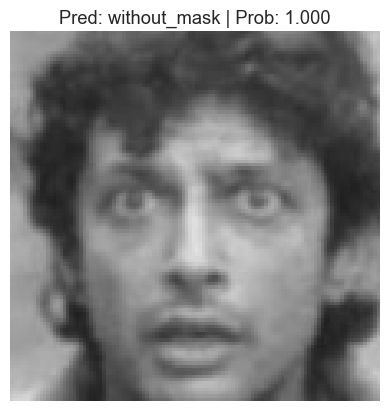

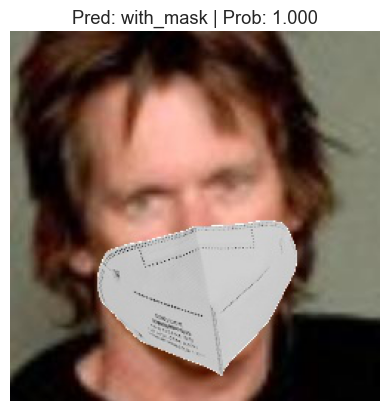

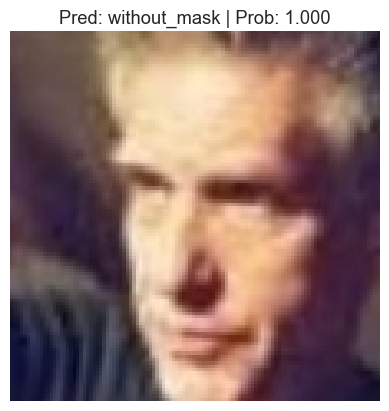

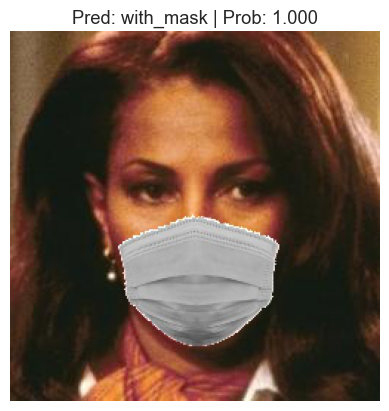

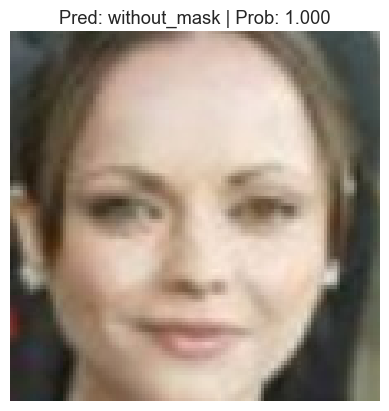

In [91]:
# Get a random list of 3 images from test set
num_images_to_plot = 5
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

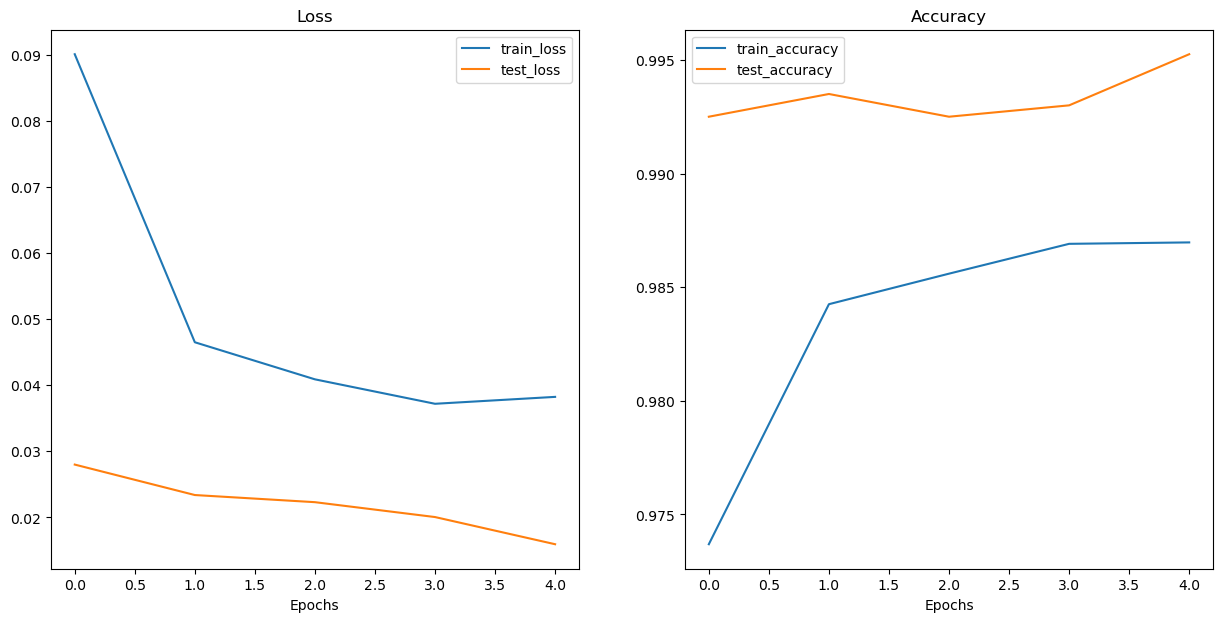

In [67]:
plot_loss_curves(results)

In [90]:
# # Change figure size and increase dpi for better resolution
# plt.figure(figsize=(8,6), dpi=100)
# # Scale up the size of all text
# sns.set(font_scale = 1.1)

# # Plot Confusion Matrix using Seaborn heatmap()
# # Parameters:
# # first param - confusion matrix in array format   
# # annot = True: show the numbers in each heatmap cell
# # fmt = 'd': show numbers as integers. 

# TP = 
# TN = 
# FP =
# FN = 

# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)


# conf_matrix = [[122,  29],
#                [ 30,  50]]
# ax = sns.heatmap(conf_matrix, annot=True, fmt='d', )

# # set x-axis label and ticks. 
# ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# # set y-axis label and ticks
# ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# # set plot title
# ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

# plt.show()